 # Урок: TensorFlow

## Задание

* Постройте нейронную сеть(берем простую линейную сеть, которую разбирали на уроке: меняем число слоев, число нейронов , типы активации, тип оптимизатора) на датасет from sklearn.datasets import load_boston.
* Измените функцию потерь и метрику для этой задачи. Постройте 10-15 вариантов и сведите результаты их работы в таблицу  Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?
* Поработайте с документацией TensorFlow 2. Найти 2-3 полезные команды TensorFlow, не разобранные на уроке (полезные для Вас).

## Импорт библиотек

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import boston_housing

from sklearn.model_selection import ParameterGrid

In [49]:
(train_data, train_target), (test_data, test_target) = boston_housing.load_data()

# приведем к диапазону (-1, 1)
train_data = (train_data / 127) - 1
test_data = (test_data / 127) - 1

In [50]:
print(f"Train shape: {train_data.shape}")

Train shape: (404, 13)


In [51]:
print(f"Test shape: {test_data.shape}")

Test shape: (102, 13)


In [52]:
train_data[:1]

array([[-0.99029551, -1.        , -0.93590551, -1.        , -0.99576378,
        -0.9516378 , -0.27795276, -0.96868583, -0.96850394,  1.41732283,
        -0.83464567,  2.12519685, -0.85259843]])

## Функции

In [53]:
def get_model(input_shape, units, layers_num, optimizer):

  model = Sequential()
  model.add(Dense(units, activation='relu', input_shape=input_shape))

  for k in range(layers_num + 1):
    units_ = 10 + (10 - k) * 10
    model.add(Dense(units_, activation='relu'))
  
  model.add(Dense(1))
  
  model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
  )
  return model

In [54]:
def plot(train_loss, test_loss, title):
  plt.figure(figsize=(20,5))
  plt.plot(train_loss, label = 'train loss')
  plt.plot(test_loss, label = 'test loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.grid('On')
  plt.title(title)
  plt.show()

## Создание модели и перебор параметров

#1 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 3, 'optimizer': 'adam', 'units': 64}


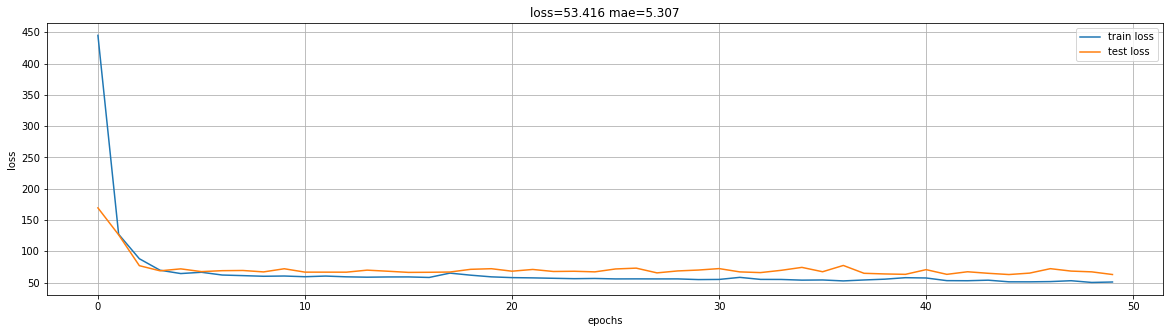

#2 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 3, 'optimizer': 'adam', 'units': 128}


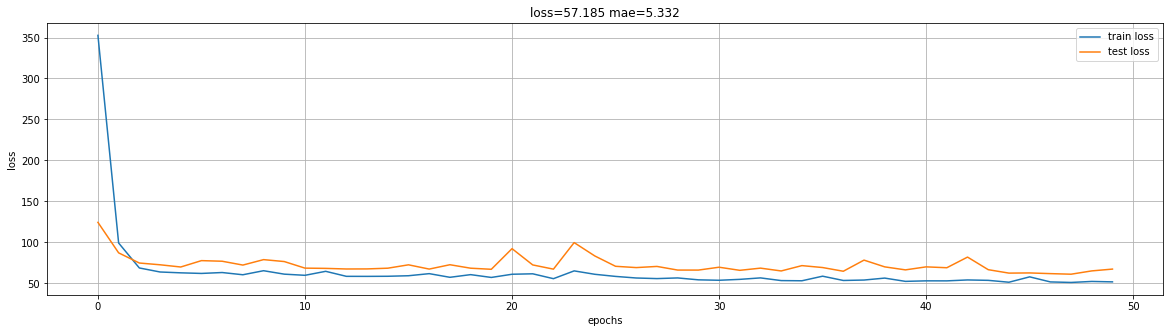

#3 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 3, 'optimizer': 'rmsprop', 'units': 64}


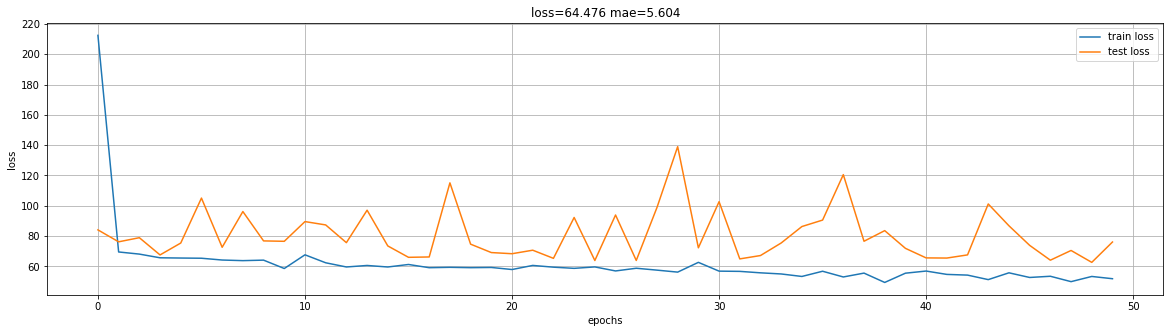

#4 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 3, 'optimizer': 'rmsprop', 'units': 128}


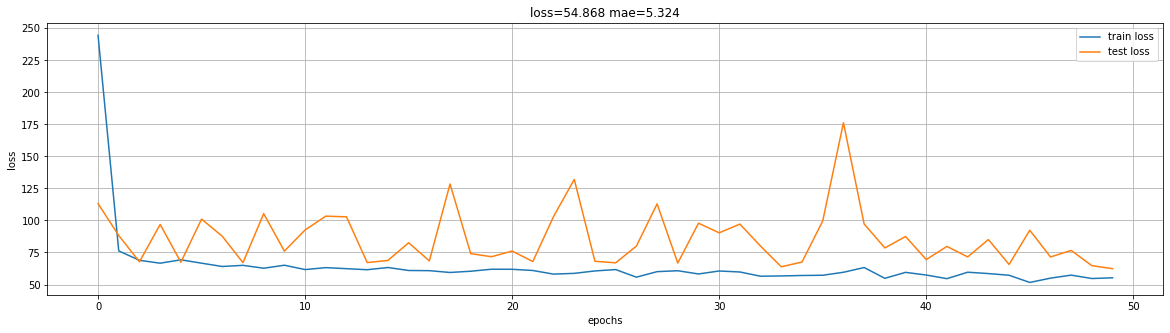

#5 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 3, 'optimizer': 'nadam', 'units': 64}


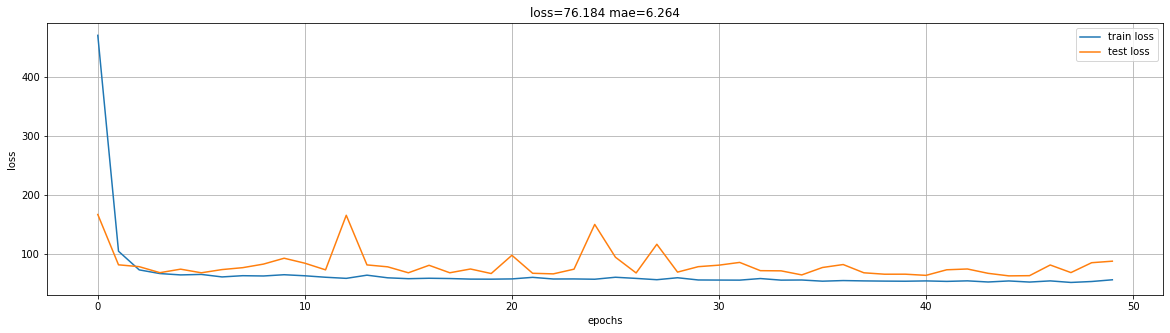

#6 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 3, 'optimizer': 'nadam', 'units': 128}


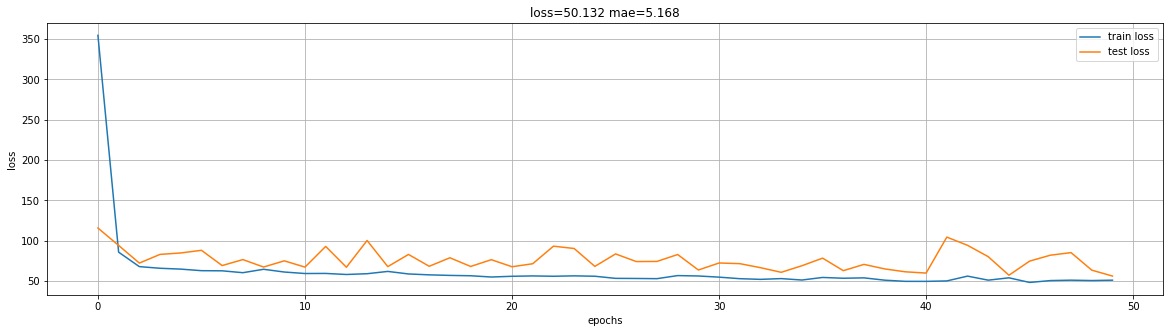

#7 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 5, 'optimizer': 'adam', 'units': 64}


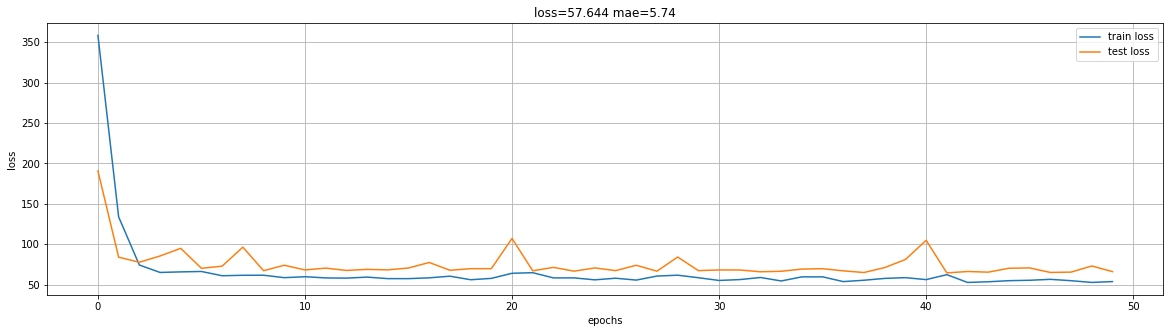

#8 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 5, 'optimizer': 'adam', 'units': 128}


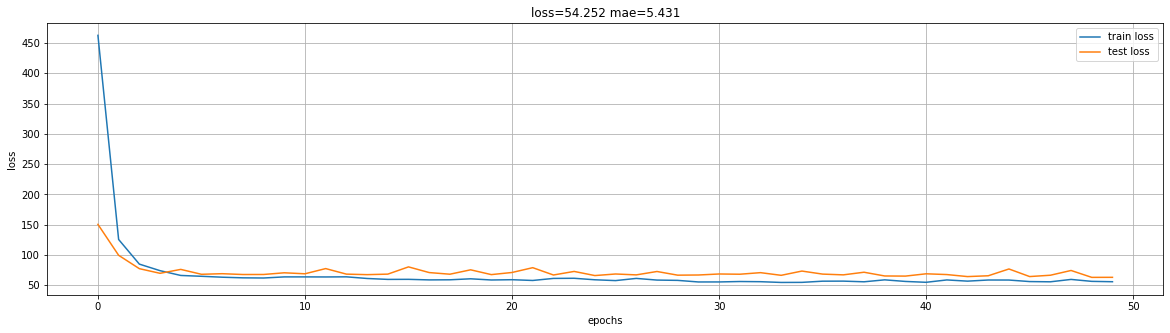

#9 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 5, 'optimizer': 'rmsprop', 'units': 64}


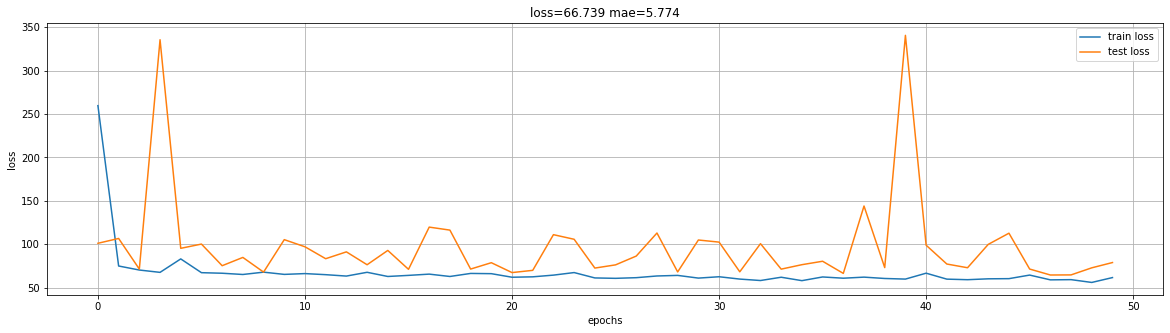

#10 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 5, 'optimizer': 'rmsprop', 'units': 128}


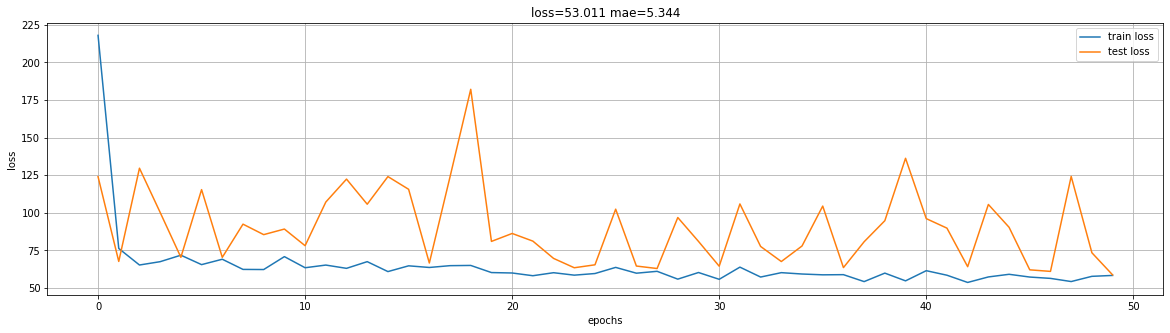

#11 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 5, 'optimizer': 'nadam', 'units': 64}


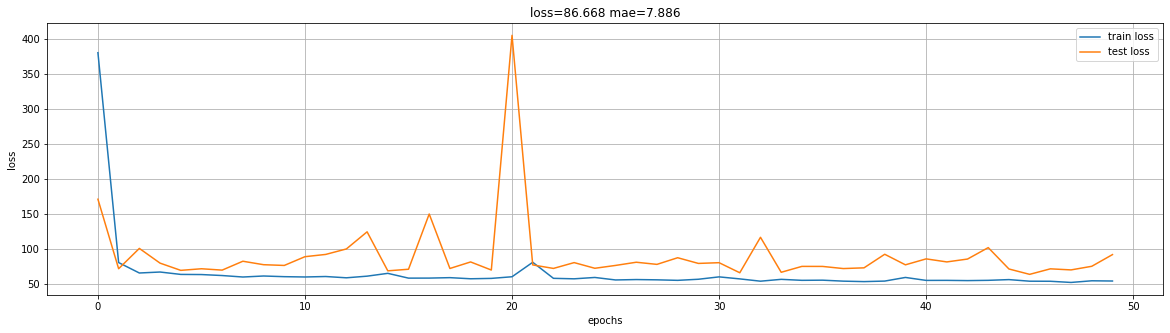

#12 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 5, 'optimizer': 'nadam', 'units': 128}


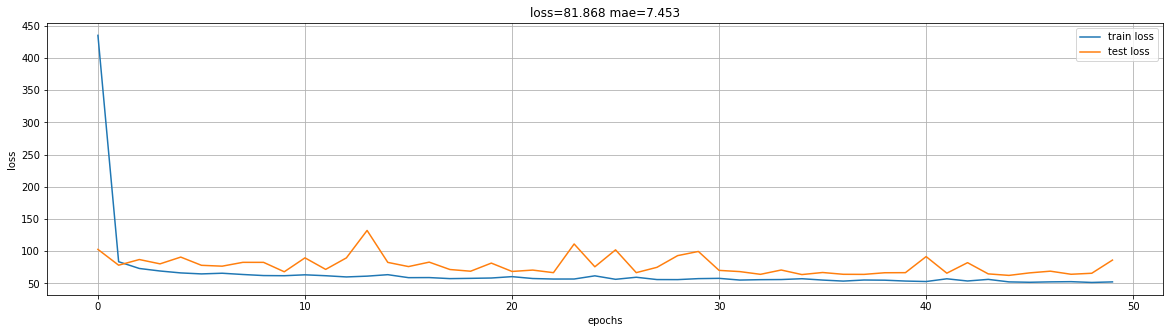

#13 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 10, 'optimizer': 'adam', 'units': 64}


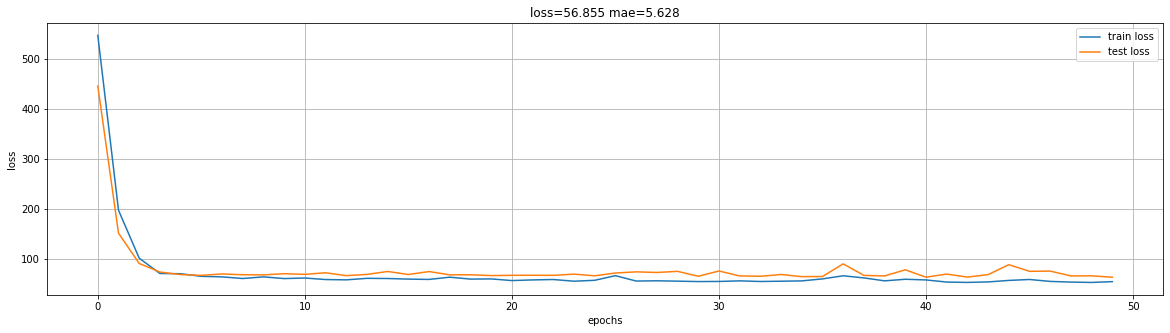

#14 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 10, 'optimizer': 'adam', 'units': 128}


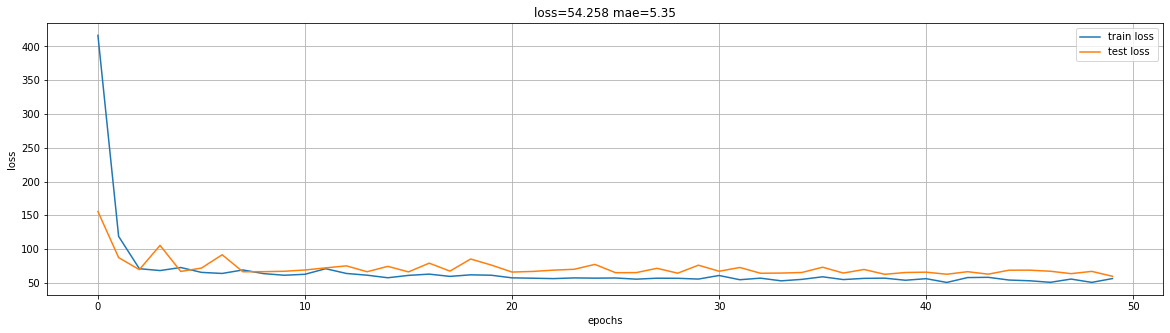

#15 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 10, 'optimizer': 'rmsprop', 'units': 64}


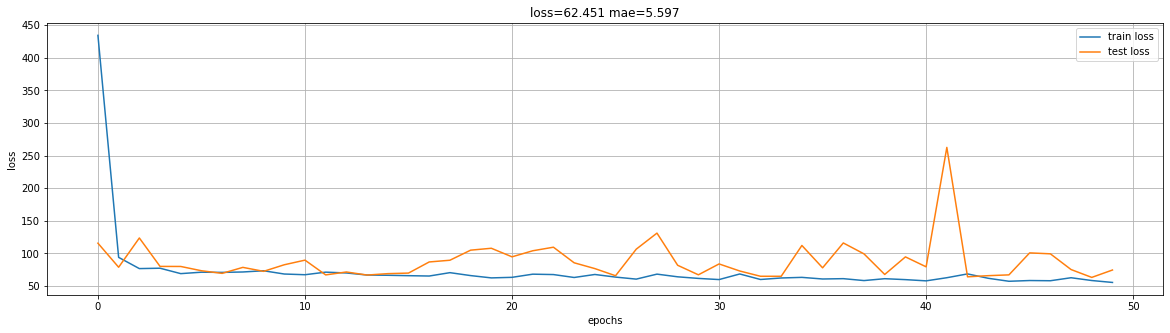

#16 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 10, 'optimizer': 'rmsprop', 'units': 128}


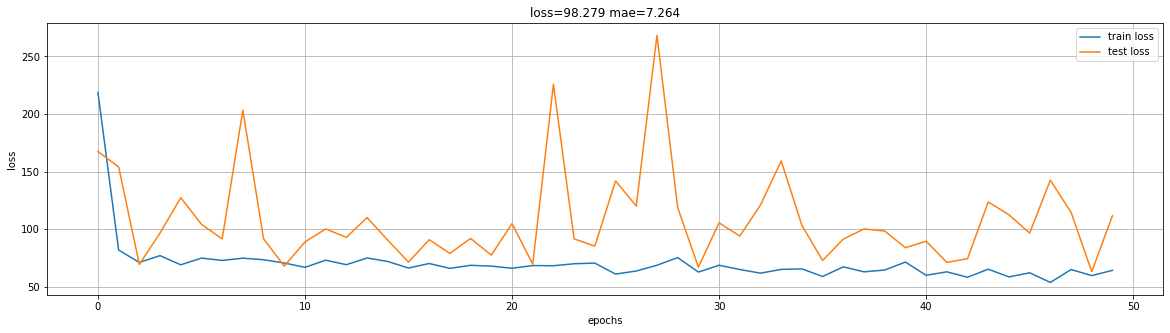

#17 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 10, 'optimizer': 'nadam', 'units': 64}


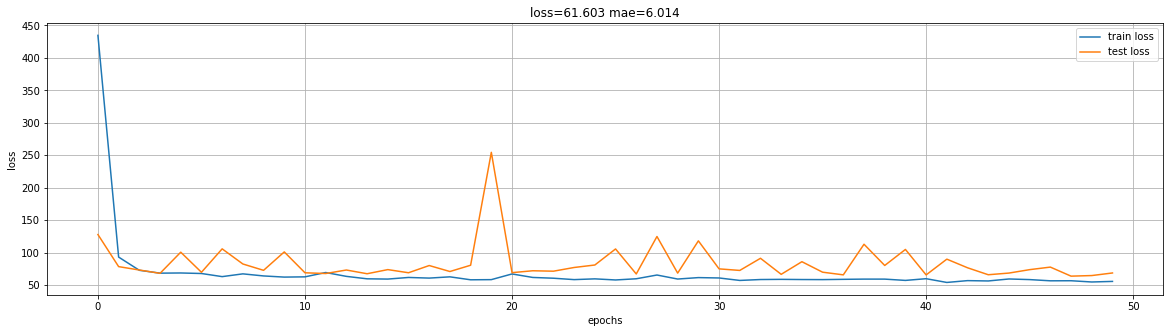

#18 from 18: {'batch_size': 16, 'epochs': 50, 'layers_num': 10, 'optimizer': 'nadam', 'units': 128}


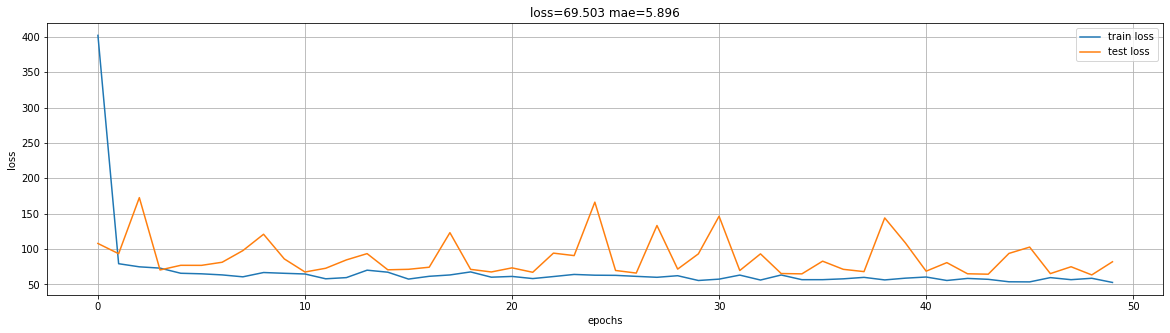

In [65]:
INPUT_SHAPE = (train_data.shape[1],)

param_grid = {
    'units': [64, 128],
    'layers_num': [3, 5, 10],
    'optimizer': ['adam', 'rmsprop', 'nadam'],
    'batch_size': [16],
    'epochs': [50],
}

results: dict = dict()
grid: list = list(ParameterGrid(param_grid))
cnt: int = 0
for params in grid:
  cnt += 1
  print(f'#{cnt} from {len(grid)}: {params}')

  model = get_model(
    INPUT_SHAPE,
    params['units'],
    params['layers_num'],
    params['optimizer'],
  )
  
  # Train
  hh = model.fit(  
    train_data,
    train_target,
    epochs=params['epochs'],
    batch_size=params['batch_size'],
    validation_split=0.2,
    verbose=0,
  )

  # Evaluate
  result = model.evaluate(
    test_data,
    test_target,
    verbose=0,
  )

  results[cnt] = {
    'mae': result[1],
    'loss': result[0],
    'params': params
  }

  plot(hh.history['loss'], hh.history['val_loss'], f'loss={round(result[0], 3)} mae={round(result[1], 3)}')

## Лучшие параметры

In [66]:
results_sorted = pd.DataFrame.from_dict(results, orient='index').sort_values(by='mae', ascending=True)
results_sorted.head(5)

,mae,loss,params
6,5.168431,50.131775,"{'batch_size': 16, 'epochs': 50, 'layers_num':..."
1,5.306907,53.415962,"{'batch_size': 16, 'epochs': 50, 'layers_num':..."
4,5.323982,54.868164,"{'batch_size': 16, 'epochs': 50, 'layers_num':..."
2,5.332450,57.184830,"{'batch_size': 16, 'epochs': 50, 'layers_num':..."
10,5.343774,53.011280,"{'batch_size': 16, 'epochs': 50, 'layers_num':..."


{'batch_size': 16, 'epochs': 10, 'layers_num': 10, 'optimizer': 'adam', 'units': 64}

## Обучение финальной модели с оптимальными параметрами

In [71]:
final_model = get_model(
  INPUT_SHAPE,
  units=128,
  layers_num=3,
  optimizer='nadam',
)

final_model.fit(  
  train_data,
  train_target,
  epochs=1000,
  batch_size=16,
  validation_split=0.2,
)

Epoch 1/1000
21/21 [==============================] - 2s 19ms/step - loss: 559.6762 - mae: 21.2212 - val_loss: 100.6370 - val_mae: 8.0799
Epoch 2/1000
21/21 [==============================] - 0s 3ms/step - loss: 97.0303 - mae: 7.4259 - val_loss: 82.7698 - val_mae: 5.8393
Epoch 3/1000
21/21 [==============================] - 0s 4ms/step - loss: 75.9592 - mae: 6.0303 - val_loss: 67.4470 - val_mae: 5.7090
Epoch 4/1000
21/21 [==============================] - 0s 3ms/step - loss: 56.8929 - mae: 5.3627 - val_loss: 70.4189 - val_mae: 5.4003
Epoch 5/1000
21/21 [==============================] - 0s 4ms/step - loss: 70.5262 - mae: 5.7062 - val_loss: 87.6874 - val_mae: 5.7480
Epoch 6/1000
21/21 [==============================] - 0s 3ms/step - loss: 86.1134 - mae: 6.3163 - val_loss: 83.3250 - val_mae: 5.5129
Epoch 7/1000
21/21 [==============================] - 0s 3ms/step - loss: 69.0669 - mae: 5.5410 - val_loss: 66.8641 - val_mae: 5.7136
Epoch 8/1000
21/21 [==============================] - 0s 3

## Валидация

In [72]:
  final_model.evaluate(
    test_data,
    test_target,
  )

4/4 [==============================] - 0s 3ms/step - loss: 25.7881 - mae: 3.2231


[25.788124084472656, 3.223054885864258]

## Вывод

Оптимальные параметры:
* batch_size=16
* layers_num=3
* optimizer=`nadam`
* units=128

При увеличинии количества эпох до 1000, удалось снизить `mae` до 3.22